In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

In [12]:
%%time
# fmt: off
subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    # "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "gật/lắc đầu",
    # "lắc đầu_Thinking": "gật/lắc đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    # "rest": 10,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

# ds = load_data(
#     "../data/DataVIN/Official",  
#     subjects=subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     max_duration=max_duration,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=moving_standardize,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

als_subjects = [
    *(f"ALS01_t{i}" for i in range(1, 11)),
    *(f"ALS02_t{i}" for i in range(1, 11)),
    *(f"ALS03_t{i}" for i in range(1, 8)),
    *(f"ALS04_t{i}" for i in range(1, 6)),
    *(f"ALS05_t{i}" for i in range(1, 5)),
    *(f"ALS06_t{i}" for i in range(1, 4)),
]

als_ds = load_data(
    "../data/DataVIN/ALS/als-patients",  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

ds = als_ds
subjects = als_subjects

# ds = BaseConcatDataset([ds, als_ds])
# subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

# list_of_ds = list()
# for _ds in ds.datasets:
#     if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
#         continue
#     list_of_ds.append(_ds)
    
# ds = BaseConcatDataset(list_of_ds)
# del list_of_ds
        
ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


trial: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 697/697 [00:04<00:00, 168.95it/s]


loaded 39 subjects - 12982 epochs
CPU times: user 32.8 s, sys: 2.5 s, total: 35.3 s
Wall time: 36.1 s


,subject,scenario,event,onset,label,label_idx,trial,split,epochs
0,ALS01_t1,nâng tay trái,Thinking,14.5376,nâng tay trái,5,0,train,20
1,ALS01_t1,nâng tay trái,Thinking,41.2796,nâng tay trái,5,1,train,20
2,ALS01_t1,nâng tay trái,Thinking,63.0225,nâng tay trái,5,2,train,20
3,ALS01_t1,nâng tay phải,Thinking,10.7208,nâng tay phải,4,0,train,19
4,ALS01_t1,nâng tay phải,Thinking,34.8467,nâng tay phải,4,1,train,23
...,...,...,...,...,...,...,...,...,...
692,ALS06_t3,gật đầu,Thinking,26.6914,gật đầu,0,1,train,19
693,ALS06_t3,gật đầu,Thinking,48.3375,gật đầu,0,2,train,26
694,ALS06_t3,lắc đầu,Thinking,4.3345,lắc đầu,1,0,train,20
695,ALS06_t3,lắc đầu,Thinking,23.5328,lắc đầu,1,1,train,23


In [1]:
window_duration = 2.0  # @param
window_stride_duration = 0.5  # @param

labels = sorted(list(set(ds_info["label"])))
print(f"{len(labels)} classes")

for label in labels:
    du = list()
    for _, r in ds_info[ds_info["label"] == label].iterrows():
        du.append((r["epochs"] - 1) * window_stride_duration + window_duration)

    print(f"{label}: {min(du)}s-{max(du)}s")
    sb.distplot(du)

plt.legend(labels)

NameError: name 'ds_info' is not defined

In [14]:
# ALS02_t9	nâng tay phải	Resting	30.896	rest	0	1	train	102

In [16]:
test_subjects = [
    *(f"ALS01_t{i}" for i in range(1, 7)),
    *(f"ALS02_t{i}" for i in range(1, 5)),
]

In [17]:
for i in range(0, len(test_subjects), 1):
    _test_subjects = set(test_subjects[i:i+1])
    print("=" * 80)
    print(f"testing on subjects: {_test_subjects}")
    print("=" * 80)
    
    prefix = test_subjects[i].split("_")[0]
    print(prefix)
    
    # -----------load data--------------
    Xtrain = list()
    Ytrain = list()
    exp_ds = list()
    test_subject_data = defaultdict(list)
    for _ds in ds.datasets:
        if _ds.description["subject"].startswith("ALS") and not _ds.description["subject"].startswith(prefix):
            continue

        if _ds.description["subject"] in _test_subjects:
            test_subject_data[_ds.description["subject"]].append(deepcopy(_ds))
        else:
            # Xtrain.append(_ds.windows.get_data())
            # Ytrain.extend(_ds.y)

            _ds0 = deepcopy(_ds)
            _ds0.description["subject"] = prefix
            exp_ds.append(_ds0)
            
    exp_ds = BaseConcatDataset(exp_ds)
    label_alignment(exp_ds, target_subject=prefix, progress_bar=False)
    euclidean_alignment(exp_ds, target_subject=None, progress_bar=False)
    for _ds in exp_ds.datasets:
        Xtrain.append(_ds.windows.get_data())
        Ytrain.extend(_ds.y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    
    for subject, test_exp_ds in test_subject_data.items():
        test_exp_ds = BaseConcatDataset(test_exp_ds)
        euclidean_alignment(test_exp_ds, target_subject=None, progress_bar=False)
        
        Xtest = list()
        Ytest = list()
        for _ds in test_exp_ds.datasets:
            Xtest.append(_ds.windows.get_data())
            Ytest.extend(_ds.y)
            
        Xtest = np.concatenate(Xtest, axis=0)
        Ytest = np.array(Ytest, dtype=int)
        
        test_subject_data[subject] = (Xtest, Ytest)
        
    # ----------classification model-----
    csp = mne.decoding.CSP(n_components=32, reg=None, log=None, rank="full", transform_into='csp_space')
    Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
    
    for subject, (Xtest, Ytest) in test_subject_data.items():
        test_subject_data[subject] = (csp.transform(Xtest), Ytest)
    
    bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
    params = dict({
        'pow_freq_bands__log': True,
        'pow_freq_bands__normalize': False,
        'pow_freq_bands__freq_bands': bands,
    })
    
    # ---------fitting-------------------
    max_nc = {k: 0 for k in test_subject_data.keys()}
    max_acc = {k: 0 for k in test_subject_data.keys()}
    max_cfm = {k: 0 for k in test_subject_data.keys()}
    for nc in tqdm(range(1, 33), desc="components"):
        fe = FeatureExtractor(sfreq=128.0, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

        clf = SVC(
            C=1.0,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        )
        
        clf.fit(fe.fit_transform(Xtrain_csp[:, :nc], Ytrain), Ytrain)
        
        # make prediction
        for subject, (Xtest_csp, Ytest) in test_subject_data.items():
            Ypred = clf.predict(fe.transform(Xtest_csp[:, :nc]))
            
            acc = metrics.balanced_accuracy_score(Ytest, Ypred)
            if acc >= max_acc[subject]:
                max_nc[subject] = nc
                max_acc[subject] = acc
                max_cfm[subject] = metrics.confusion_matrix(Ytest, Ypred)
                
    # ---------print result---------------
    for subject, acc in max_acc.items():
        print(f"subject {subject} - acc: {acc} ({max_nc[subject]} components)")
        print(max_cfm[subject])

testing on subjects: {'ALS01_t1'}
ALS01


components: 100%|██████████| 32/32 [09:34<00:00, 17.96s/it]


subject ALS01_t1 - acc: 0.7252136752136752 (24 components)
[[98  4  2]
 [ 1 52  7]
 [ 7 31 22]]
testing on subjects: {'ALS01_t2'}
ALS01


components: 100%|██████████| 32/32 [09:30<00:00, 17.84s/it]


subject ALS01_t2 - acc: 0.6748202414869082 (21 components)
[[84 21 25]
 [ 3 44  9]
 [ 6 16 32]]
testing on subjects: {'ALS01_t3'}
ALS01


components: 100%|██████████| 32/32 [09:28<00:00, 17.76s/it]


subject ALS01_t3 - acc: 0.6260251503553854 (1 components)
[[56  0  0]
 [ 6 48  5]
 [ 8 50  4]]
testing on subjects: {'ALS01_t4'}
ALS01


components: 100%|██████████| 32/32 [09:16<00:00, 17.39s/it]


subject ALS01_t4 - acc: 0.5065368344883249 (1 components)
[[35 21  2]
 [ 5 53  1]
 [32 23  1]]
testing on subjects: {'ALS01_t5'}
ALS01


components: 100%|██████████| 32/32 [09:42<00:00, 18.21s/it]


subject ALS01_t5 - acc: 0.7160067391318489 (12 components)
[[60  0  2]
 [ 2 26 29]
 [11  5 42]]
testing on subjects: {'ALS01_t6'}
ALS01


components: 100%|██████████| 32/32 [09:09<00:00, 17.18s/it]


subject ALS01_t6 - acc: 0.725438596491228 (31 components)
[[52  0  0]
 [15 30 12]
 [ 9 12 39]]
testing on subjects: {'ALS02_t1'}
ALS02


components: 100%|██████████| 32/32 [08:30<00:00, 15.94s/it]


subject ALS02_t1 - acc: 0.5543566193965926 (14 components)
[[63  6 10]
 [12 19 25]
 [21  6 30]]
testing on subjects: {'ALS02_t2'}
ALS02


components: 100%|██████████| 32/32 [09:24<00:00, 17.64s/it]


subject ALS02_t2 - acc: 0.4887914230019493 (1 components)
[[25  3  8]
 [13 14 30]
 [16 11 30]]
testing on subjects: {'ALS02_t3'}
ALS02


components: 100%|██████████| 32/32 [08:41<00:00, 16.29s/it]


subject ALS02_t3 - acc: 0.6066328612228244 (12 components)
[[22 12  9]
 [ 7 32 17]
 [ 7  8 42]]
testing on subjects: {'ALS02_t4'}
ALS02


components: 100%|██████████| 32/32 [08:28<00:00, 15.88s/it]

subject ALS02_t4 - acc: 0.49182277728218854 (2 components)
[[30 21  6]
 [ 8 43  8]
 [11 35 13]]


In [9]:
raw = mne.io.read_raw_edf("../data/DataVIN/ALS/als-patients/ALS02_t9/sample2/EEG.edf", preload=False, verbose=False)
raw.pick_channels(ch_names=channels, ordered=True)
raw.set_montage("standard_1020")

<RawEDF | EEG.edf, 32 x 17408 (136.0 s), ~49 kB, data not loaded>

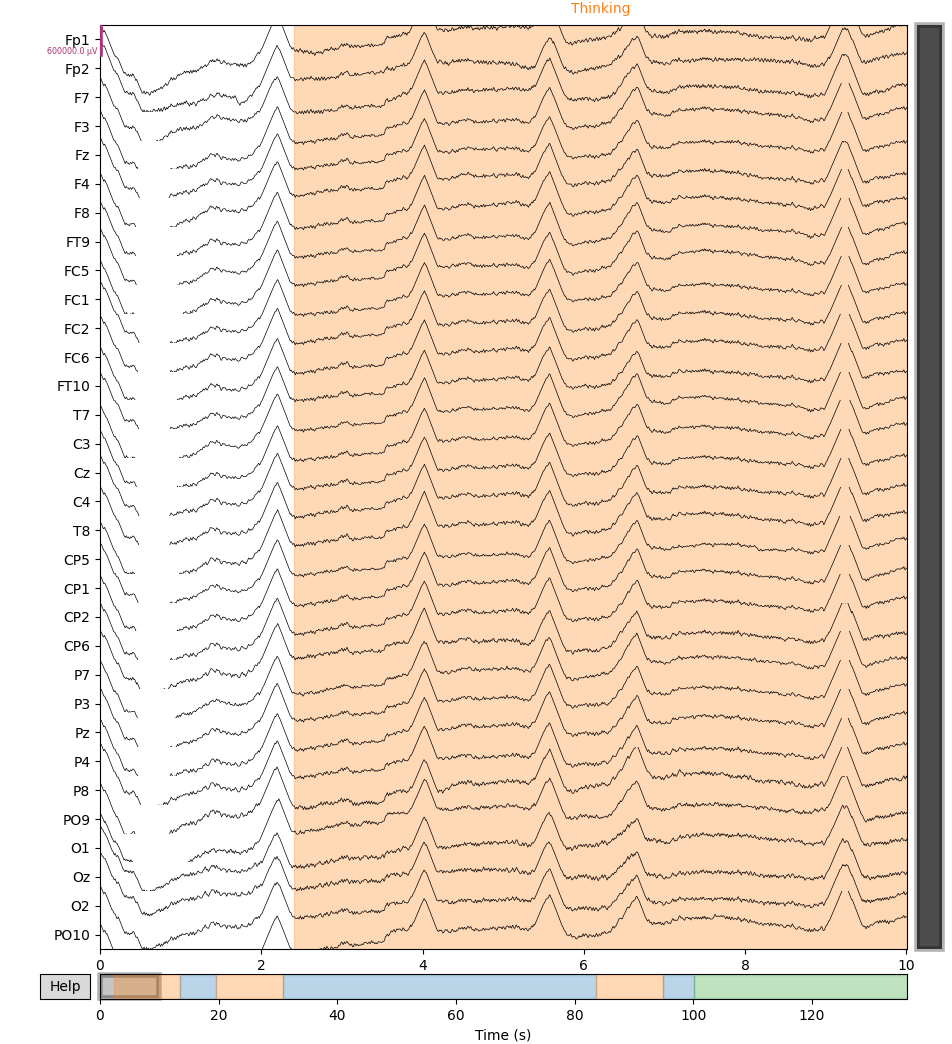

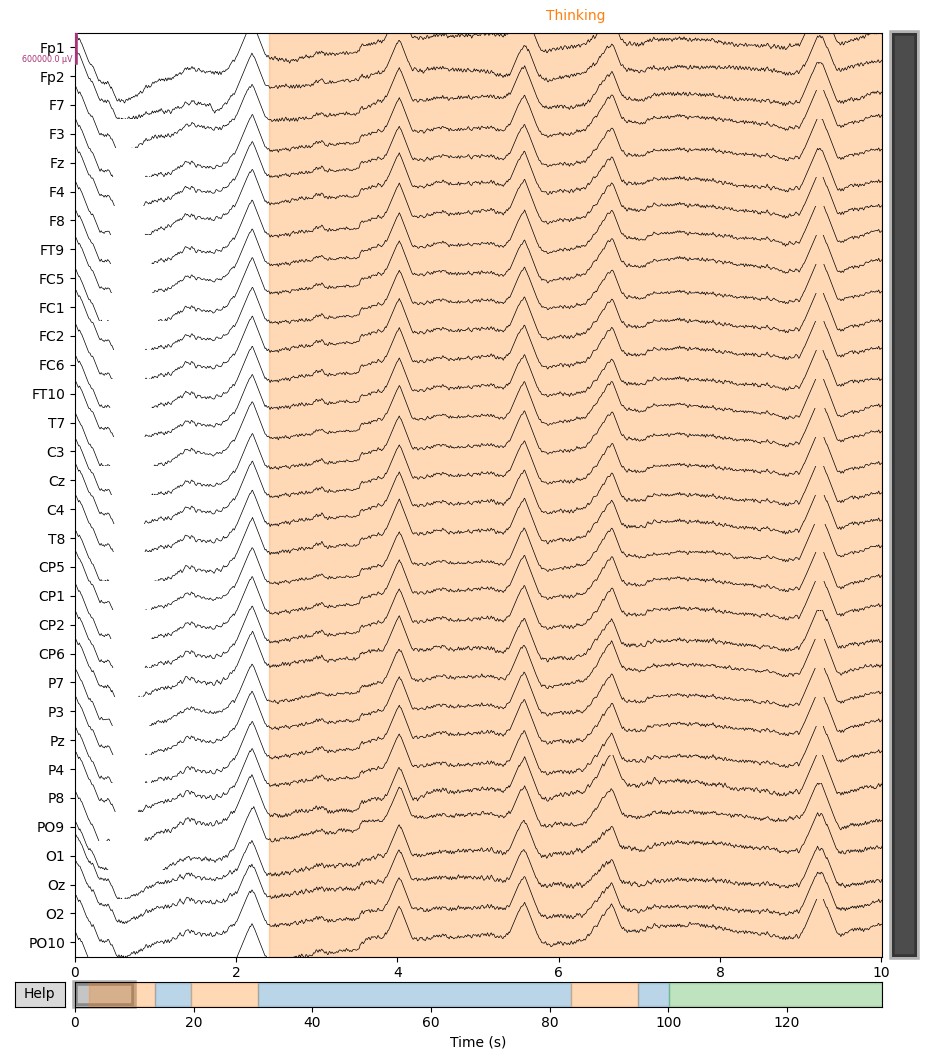

In [10]:
%matplotlib widget

raw.plot(n_channels=32, scalings={"eeg": 0.3})